# Dependencies

In [1]:
import keras 
from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras import backend as K
from keras.preprocessing.image import img_to_array
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.utils import np_utils

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, roc_curve
from sklearn.externals import joblib
from sklearn.preprocessing import LabelEncoder

from random import shuffle

import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import os
import cv2

Using TensorFlow backend.
/Users/bp/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/bp/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/bp/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/bp/anaconda/lib/python3.6/site-packages/tensorflow/python/fra

In [2]:
print("Keras version:", keras.__version__)
print("Sklearn version:", sklearn.__version__)
print("Pandas version:", pd.__version__)
print("Numpy version:", np.__version__)
print("Matplotlib version:", matplotlib.__version__)

Keras version: 2.3.1
Sklearn version: 0.20.3
Pandas version: 0.24.2
Numpy version: 1.17.3
Matplotlib version: 2.2.2


# Load Data

In [4]:
#Import the MNIST dataset
(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test2 = train_test_split(X_train, test_size=0.8, random_state=42)

In [6]:
print("Training data shape: ", X_train.shape)

print("Testing data shape: ", X_test.shape)

Training data shape:  (12000, 28, 28)
Testing data shape:  (10000, 28, 28)


# Build the Models

In [7]:
#Shape the data

X_train_MLP = X_train.reshape((X_train.shape[0], -1))
X_test_MLP = X_test.reshape((X_test.shape[0], -1))
print("Training data_MLP shape: ", X_train_MLP.shape)
print("Testing data_MLP shape: ", X_test_MLP.shape)

X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
print("Training data shape: ", X_train.shape)
print("Testing data shape: ", X_test.shape)

Training data_MLP shape:  (12000, 784)
Testing data_MLP shape:  (10000, 784)
Training data shape:  (12000, 28, 28, 1)
Testing data shape:  (10000, 28, 28, 1)


In [11]:
INPUT_SIZE = 784
HIDDEN_ONE = 256
HIDDEN_TWO = 128
HIDDEN_THREE = 64
ENCODING_SIZE = 32

input_MLP = Input(shape=(INPUT_SIZE,))
MLP_encode = Dense(HIDDEN_ONE, activation='relu')(input_MLP)
MLP_encode = Dense(HIDDEN_TWO, activation='relu')(MLP_encode)
MLP_encode = Dense(HIDDEN_THREE, activation='relu')(MLP_encode)

MLP_encode = Dense(ENCODING_SIZE, activation='relu')(MLP_encode)

MLP_decode = Dense(HIDDEN_THREE, activation='relu')(MLP_encode)
MLP_decode = Dense(HIDDEN_TWO, activation='relu')(MLP_decode)
MLP_decode = Dense(HIDDEN_ONE, activation='relu')(MLP_decode)
MLP_decode = Dense(INPUT_SIZE, activation='relu')(MLP_decode)
autoencoder_MLP = Model(input_MLP, MLP_decode)

In [12]:
autoencoder_MLP.compile(optimizer='adam',loss='mean_squared_error')

autoencoder_MLP.fit(X_train_MLP,
                   X_train_MLP,
                   epochs=10,
                   batch_size=64,
                   shuffle=True,
                   validation_split=0.2)

decoded_MLP = autoencoder_MLP.predict(X_test_MLP)

Train on 9600 samples, validate on 2400 samples
Epoch 1/10
9600/9600 [==============================] - 1s 135us/step - loss: 0.0544 - val_loss: 0.0346
Epoch 2/10
9600/9600 [==============================] - 1s 99us/step - loss: 0.0309 - val_loss: 0.0279
Epoch 3/10
9600/9600 [==============================] - 1s 99us/step - loss: 0.0261 - val_loss: 0.0247
Epoch 4/10
9600/9600 [==============================] - 1s 97us/step - loss: 0.0234 - val_loss: 0.0228
Epoch 5/10
9600/9600 [==============================] - 1s 97us/step - loss: 0.0218 - val_loss: 0.0217
Epoch 6/10
9600/9600 [==============================] - 1s 98us/step - loss: 0.0207 - val_loss: 0.0207
Epoch 7/10
9600/9600 [==============================] - 1s 98us/step - loss: 0.0197 - val_loss: 0.0198
Epoch 8/10
9600/9600 [==============================] - 1s 110us/step - loss: 0.0191 - val_loss: 0.0192
Epoch 9/10
9600/9600 [==============================] - 1s 98us/step - loss: 0.0184 - val_loss: 0.0186
Epoch 10/10
9600/9600 [

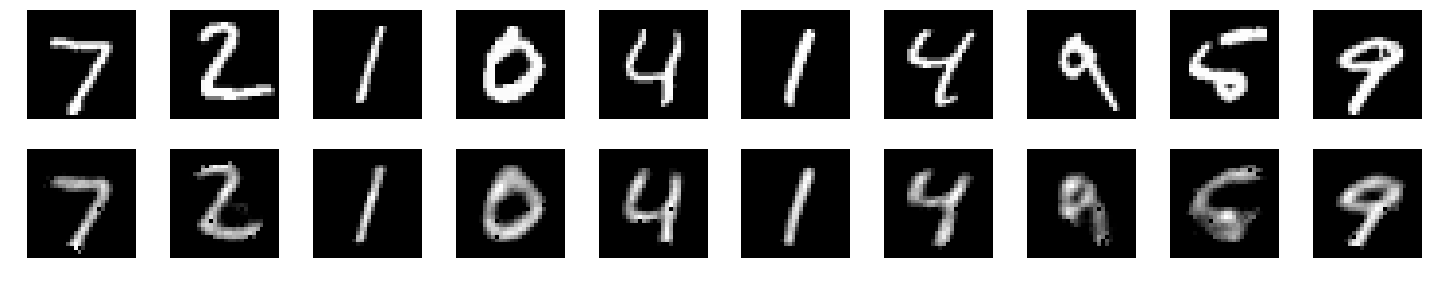

In [13]:
plt.figure(figsize=(20,4))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(X_test_MLP[i].reshape(28,28))
    plt.gray()
    plt.axis('off')
    
    plt.subplot(2,10,i+1+10)
    plt.imshow(decoded_MLP[i].reshape(28,28))
    plt.gray()
    plt.axis('off')

plt.tight_layout()
plt.show()